In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
import matplotlib.patches as mpatches
import matplotlib.dates as mdates



## Data Handling

In [4]:
# Import csv file from data folder
data = pd.read_csv('../Data/Price.csv')

# Explore data
print("Columns of dataset:", data.columns)
print("Price Areas: ", data['PriceArea'].unique())

# Filter all rows that do not equal DE for the column Country
data = data[data['PriceArea'] == 'DK2'].reset_index(drop=True) # adjust for DK2
data = data.drop(columns=['PriceDKK', 'PriceArea'])
data = data.rename(columns={'HourDK': 'Date', 'PriceEUR': 'Price', 'HourUTC': 'Hour'})
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')  # Convert to standard format
data['Hour'] = pd.to_timedelta(data['Hour']) + pd.Timedelta(hours=1) # Shift to UTC+1
data['Hour'] = data['Hour'].apply(lambda x: x - pd.Timedelta(days=1) if x >= pd.Timedelta(days=1) else x) # Handles the 24:00:00 case
data['Datetime'] = pd.to_datetime(data['Date']) + data['Hour']
data['Hour'] = data['Hour'].apply(lambda x: str(x).split(' ')[-1])
data['Hour'] = (pd.to_datetime(data['Hour'], format='%H:%M:%S')).dt.time
data.head(25)

Columns of dataset: Index(['HourUTC', 'HourDK', 'PriceArea', 'PriceDKK', 'PriceEUR'], dtype='object')
Price Areas:  ['DE' 'SE3' 'DK2' 'DK1' 'NO2' 'SE4' 'SYSTEM']


,Hour,Date,Price,Datetime
0,00:00:00,2021-01-01,50.869999,2021-01-01 00:00:00
1,01:00:00,2021-01-01,48.189999,2021-01-01 01:00:00
2,02:00:00,2021-01-01,44.680000,2021-01-01 02:00:00
3,03:00:00,2021-01-01,42.919998,2021-01-01 03:00:00
4,04:00:00,2021-01-01,40.389999,2021-01-01 04:00:00
5,05:00:00,2021-01-01,40.200001,2021-01-01 05:00:00
6,06:00:00,2021-01-01,39.630001,2021-01-01 06:00:00
7,07:00:00,2021-01-01,40.090000,2021-01-01 07:00:00
8,08:00:00,2021-01-01,41.270000,2021-01-01 08:00:00
9,09:00:00,2021-01-01,44.880001,2021-01-01 09:00:00


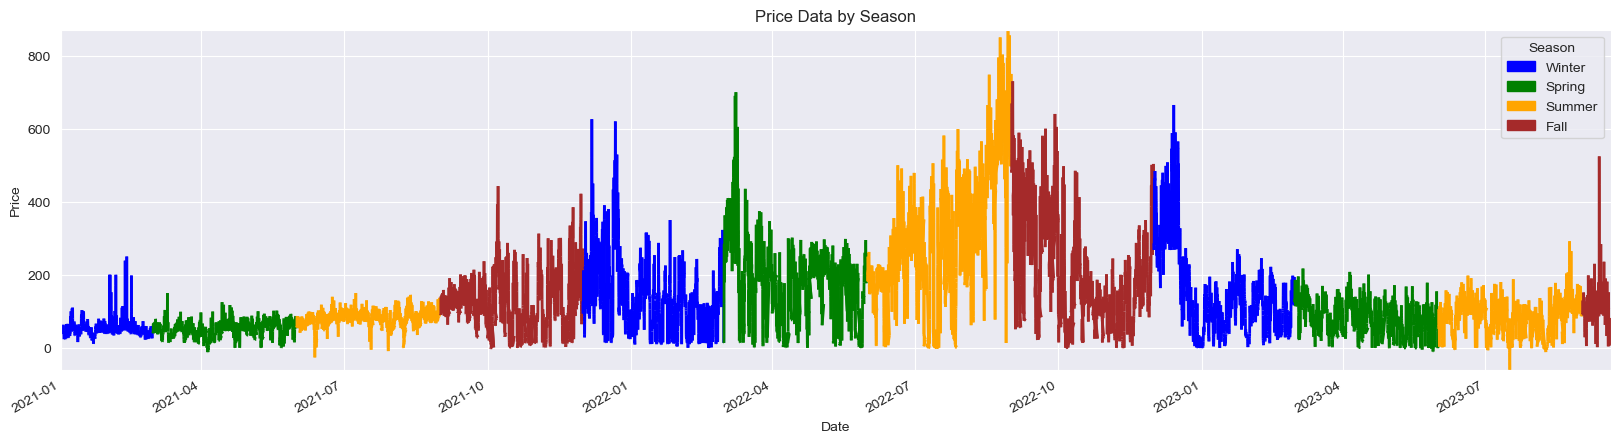

In [5]:
# Define seasons
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# Add a season column
data['Season'] = data['Datetime'].apply(get_season)

# Map seasons to colors
season_colors = {'Winter': 'blue', 'Spring': 'green', 'Summer': 'orange', 'Fall': 'brown'}
data['Color'] = data['Season'].map(season_colors)

# Prepare data for LineCollection
dates = data['Datetime'].values
prices = data['Price'].values
points = np.array([mdates.date2num(dates), prices]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
colors = data['Color'].values[:-1]  # Create color array for segments

# Create LineCollection
lc = LineCollection(segments, colors=colors, linewidths=2)

# Plot
fig, ax = plt.subplots(figsize=(20, 5))
ax.add_collection(lc)
ax.set_xlim(dates.min(), dates.max())
ax.set_ylim(prices.min(), prices.max())
ax.set_title('Price Data by Season')
ax.set_xlabel('Date')
ax.set_ylabel('Price')

# Format x-axis with proper dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()

# Create custom legend
legend_handles = [mpatches.Patch(color=color, label=season) for season, color in season_colors.items()]
ax.legend(handles=legend_handles, title='Season')
plt.show()

# Drop auxiliary columns
data = data.drop(columns=['Season', 'Color'])

## Price categorization

In [6]:
def dynamic_categorization(df, column, time_column, window_size):
    # Ensure the time column is sorted and in datetime format
    df[time_column] = pd.to_datetime(df[time_column])
    df = df.sort_values(by=[time_column, 'Hour'])

    # Compute rolling statistics (mean+std)
    df['RollingMean'] = df[column].rolling(window=window_size, min_periods=1).mean()
    df['RollingStd'] = df[column].rolling(window=window_size, min_periods=1).std() # 2 values needed for std -> first row will always be NaN!

    # Fill NaN std values with a small constant (e.g., 1) to avoid division errors
    df['RollingStd'] = df['RollingStd'].fillna(1)

    # Compute Z-scores
    df['ZScore'] = (df[column] - df['RollingMean']) / df['RollingStd']

    # Categorize based on Z-scores
    bins = [-float('inf'), -1.5, -0.5, 0.5, 1.5, float('inf')]
    labels = ['Very Low', 'Low', 'Normal', 'High', 'Very High']
    df['Category'] = pd.cut(df['ZScore'], bins=bins, labels=labels)

    return df

# Apply function to categorize
categorized_data = dynamic_categorization(data, column='Price', time_column='Date', window_size=168)
categorized_data

,Hour,Date,Price,Datetime,RollingMean,RollingStd,ZScore,Category
0,00:00:00,2021-01-01,50.869999,2021-01-01 00:00:00,50.869999,1.000000,0.000000,Normal
1,01:00:00,2021-01-01,48.189999,2021-01-01 01:00:00,49.529999,1.895046,-0.707107,Low
2,02:00:00,2021-01-01,44.680000,2021-01-01 02:00:00,47.913333,3.104260,-1.041579,Low
3,03:00:00,2021-01-01,42.919998,2021-01-01 03:00:00,46.664999,3.557757,-1.052630,Low
4,04:00:00,2021-01-01,40.389999,2021-01-01 04:00:00,45.409999,4.167535,-1.204549,Low
...,...,...,...,...,...,...,...,...
23779,19:00:00,2023-09-18,81.790001,2023-09-18 19:00:00,97.528988,47.824622,-0.329098,Normal
23780,20:00:00,2023-09-18,29.870001,2023-09-18 20:00:00,96.378750,47.104569,-1.411938,Low
23781,21:00:00,2023-09-18,27.139999,2023-09-18 21:00:00,95.660357,47.235327,-1.450617,Low
23782,22:00:00,2023-09-18,25.709999,2023-09-18 22:00:00,95.099464,47.503994,-1.460708,Low


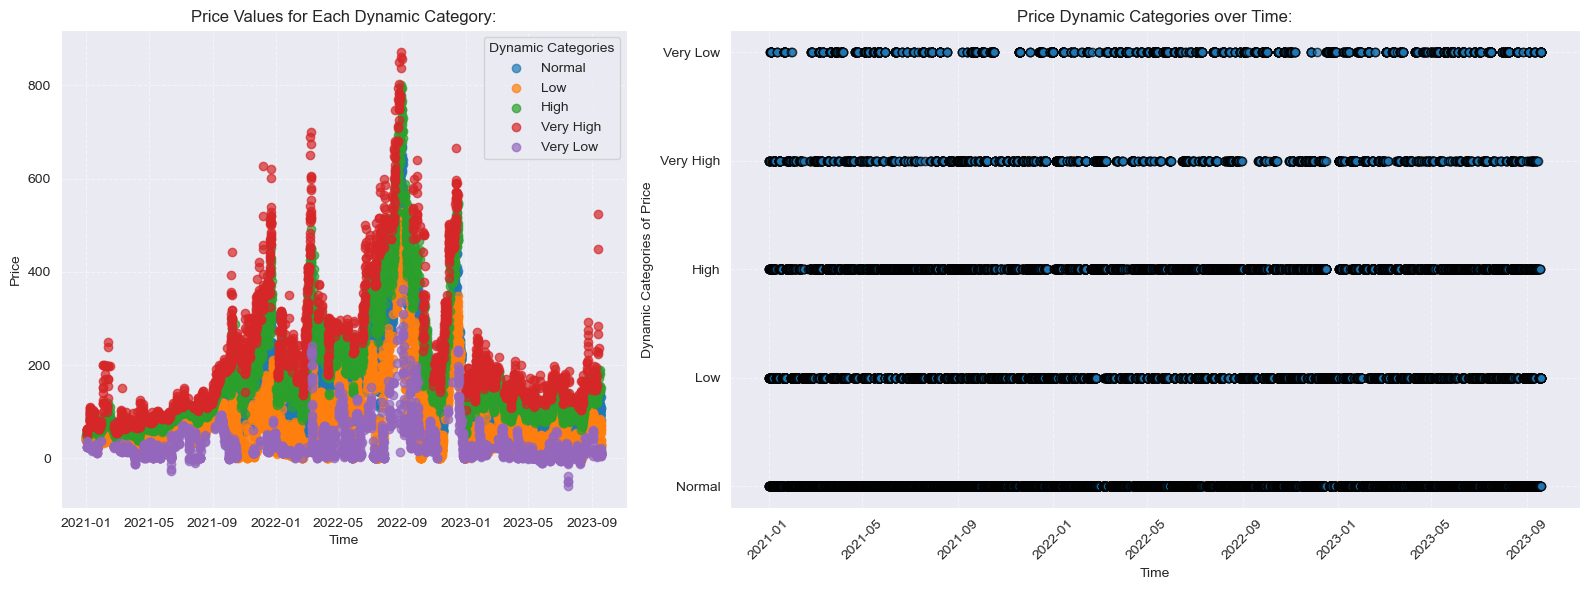

In [7]:
def plot_dynamic_categorization(df, column, time_column):
    """
    Create a subplot with the dynamically categorized data scatter plot on the right
    and line plots of the values for each dynamic category on the left.

    Parameters:
        df (pd.DataFrame): The input dataframe containing the categorized data.
        column (str): The column to analyze and plot.
        time_column (str): The time column to use for the x-axis.
    
    Returns:
        None: Displays a subplot with the categorized data and category-based line plots.
    """
    # Ensure time column is in datetime format and sorted
    df[time_column] = pd.to_datetime(df[time_column])
    df = df.sort_values(by=time_column)

    # Get unique categories for dynamic labeling
    unique_categories = df['Category'].dropna().unique()

    # Set up subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 3]})

    # Plot scatter plots of values for each dynamic category (left plot)
    for category in unique_categories:
        category_df = df[df['Category'] == category]
        axes[0].scatter(category_df[time_column], category_df[column], label=category, alpha=0.7)
    axes[0].set_title(f"{column} Values for Each Dynamic Category:")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel(column)
    axes[0].legend(title="Dynamic Categories")
    axes[0].grid(True, linestyle='--', alpha=0.5)

    # Plot scatter plot of dynamic categories over time (right plot)
    axes[1].scatter(df[time_column], df['Category'], alpha=0.7, edgecolor='k')
    axes[1].set_title(f"{column} Dynamic Categories over Time:")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel(f"Dynamic Categories of {column}")
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# Apply function to plot
plot_dynamic_categorization(categorized_data, column='Price', time_column='Datetime')

## Transition Matrix

In [8]:
def calculate_transition_matrix(df, category_column="Category"):
    """
    Calculate the transition probability matrix for categories.

    Args:
    - df: DataFrame with a sequential column of categories.
    - category_column: Name of the column containing the categories.

    Returns:
    - 4x4 transition probability matrix as a DataFrame.
    """
    # Ensure the column exists
    if category_column not in df.columns:
        raise ValueError(f"Column '{category_column}' not found in the DataFrame.")

    # Extract categories from input df

    categories = df[category_column].unique()
    transitions = df[category_column].values


    # Initialize a 4x4 matrix for counts
    transition_counts = pd.DataFrame(
        np.zeros((len(categories), len(categories))),
        index=categories,
        columns=categories,
    )

    # Count transitions
    for i in range(len(transitions) - 1):
        current_category = transitions[i]
        next_category = transitions[i + 1]
        if current_category in categories and next_category in categories:
            transition_counts.loc[current_category, next_category] += 1

    # Normalize rows to get probabilities
    transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0).fillna(0)

    return transition_matrix

# Calculate transition matrix
transition_matrix = calculate_transition_matrix(categorized_data)
transition_matrix

,Normal,Low,High,Very High,Very Low
Normal,0.755034,0.098969,0.135069,0.004543,0.006385
Low,0.139462,0.793235,0.012142,0.000694,0.054467
High,0.190165,0.011348,0.700138,0.095426,0.002923
Very High,0.013056,0.002901,0.272244,0.711799,0.000000
Very Low,0.028658,0.157868,0.005530,0.000000,0.807944


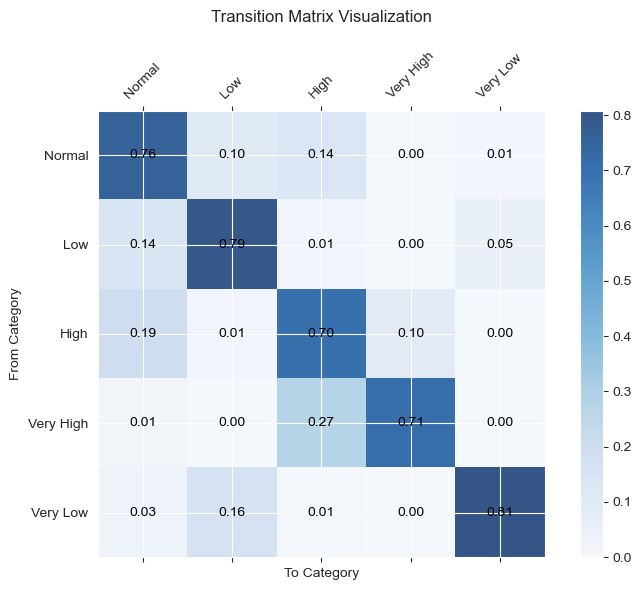

In [9]:
# Plotting the transition matrix
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(transition_matrix.values, cmap='Blues', alpha=0.8)

# Add text annotations
for (i, j), val in np.ndenumerate(transition_matrix.values):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

# Formatting the plot
plt.xticks(range(len(transition_matrix.columns)), transition_matrix.columns, rotation=45)
plt.yticks(range(len(transition_matrix.index)), transition_matrix.index)
plt.title("Transition Matrix Visualization", pad=20)
plt.xlabel("To Category")
plt.ylabel("From Category")
plt.colorbar(cax)
plt.tight_layout()
plt.show()



## MDP Model (using the value iteration algorithm to define the best policy)

In [10]:
class BatteryValueIteration:
    def __init__(self, soc_levels, actions, price_dict, price_series, price_categories, transition_matrix, gamma=0.9, epsilon=0.01, initial_SOC= 200):
        """
        Initialize the Battery Value Iteration problem.
        
        Args:
        - soc_levels: List of SOC levels (e.g., [0, 100, 200, ..., 500]).
        - actions: List of actions (e.g., ["Charge", "Discharge", "Nothing"]).
        - price_series: DataFrame with columns ['Hour', 'Category', 'Price'].
        - price_categories: List of unique price categories (e.g., ["Negative", "Low", "Medium", "High"]).
        - transition_matrix: Transition probability matrix (dict of dicts).
        - gamma: Discount factor (default 0.9).
        - epsilon: Convergence threshold for value iteration (default 0.01).
        """
        self.soc_levels = soc_levels
        self.actions = actions
        self.price_dict = price_dict
        self.price_cat_t = price_series['Category']
        self.price_t = price_series['Price']
        self.price_categories = price_categories
        self.transition_matrix = transition_matrix.T  # Transpose for correct indexing
        self.gamma = gamma
        self.epsilon = epsilon
        
        # Define all possible states as (SOC, PriceCategory)
        self.states = [(soc, category) for soc in soc_levels for category in price_categories]
        
        # Initialize value function and policy
        self.value_function = {state: 0 for state in self.states}
        self.policy = {state: "Nothing" for state in self.states}

        # Initialize state
        self.init_state = (initial_SOC, self.price_cat_t[0])
        print((initial_SOC, self.price_cat_t[0]))


    def is_valid_action(self, soc, action):
        """Check if the action is valid given the SOC."""
        valid = not (
            (action == "Discharge" and soc == 0) or
            (action == "Charge" and soc == max(self.soc_levels))
        )
        #print(f"Action: {action}, SOC: {soc}, Valid: {valid}")  # Debugging action validity
        return valid

    def get_next_soc(self, soc, action):
        """Determine the next SOC based on the action."""
        if action == "Charge":
            return min(soc + 100, max(self.soc_levels))
        elif action == "Discharge":
            return max(soc - 100, 0)
        return soc

    def reward(self, action, price):
        """Calculate the reward for a given action and price."""
        if action == "Charge":
            return -100 * price  # Cost of charging
        elif action == "Discharge":
            return 100 * price  # Revenue from discharging
        return 0  # No cost/reward for doing nothing

    def value_iteration(self):
        """Perform the value iteration algorithm."""
        iteration = 0
        self.deltas = []
        
        while True:
            iteration += 1
            delta = 0  # Track convergence
            new_value_function = self.value_function.copy()

            for state in self.states:
                soc, price_category = state
                action_values = []
                action_feas = []

                for action in self.actions:
                    # Enforce validity check
                    if not self.is_valid_action(soc, action):
                        continue  ## to check
                    
                    #print(f"Feasible action {state, action}")
                    next_soc = self.get_next_soc(soc, action)
                    expected_value = 0

                    for next_category, prob in self.transition_matrix[price_category].items():
                        next_state = (next_soc, next_category)
                        if next_state in self.states:
                            reward = self.reward(action, self.price_dict[next_category])
                            expected_value += prob * (reward + self.gamma * self.value_function[next_state])

                    action_values.append(expected_value)
                    action_feas.append(action)

                # Debugging: Print state and valid actions
                #print(f"State: {state}, Valid Actions: {action_values}")

                # Update the value function and policy only if valid actions exist
                if action_values:
                    best_action_index = np.argmax(action_values)
                    new_value_function[state] = action_values[best_action_index]
                    self.policy[state] = action_feas[best_action_index]
                else:
                    # No valid actions; set default values
                    new_value_function[state] = self.value_function[state]
                    self.policy[state] = "Nothing"

                delta = max(delta, abs(new_value_function[state] - self.value_function[state]))

            self.value_function = new_value_function

            # Display convergence status
            #if iteration % 10 == 0:
                #print(f"Iteration {iteration}: Delta={delta}")
            self.deltas.append(delta)

            # Check for convergence
            if delta < self.epsilon:
                break

    def get_policy(self):
        """Return the computed policy."""
        return self.policy

    def get_value_function(self):
        """Return the computed value function."""
        return self.value_function
    
    def test_on_data(self, price_series):
        """Test the policy on a given price series."""
        self.rewards = []
        self.battery_actions = []
        reward_cumul = 0
        self.state = self.init_state
        for i in range(len(price_series) - 1):
            soc, price_category = self.state
            action = self.policy[self.state]
            reward = self.reward(action, price_series['Price'].iloc[i])
            reward_cumul += reward
            self.rewards.append(reward_cumul)
            self.battery_actions.append((self.state, action, price_series['Price'].iloc[i], price_category))
            next_soc = self.get_next_soc(soc, action)
            self.state = (next_soc, price_series['Category'].iloc[i + 1])
    



In [11]:
# SOC levels and actions
soc_levels = [0, 100, 200, 300, 400, 500]
# soc_levels = [0, 100]
actions = ["Charge", "Discharge", "Nothing"]
price_dict = {'Very Low': 0.1, 'Low': 0.3, 'Normal': 0.5, 'High': 0.7,  'Very High': 0.9}
price_categories = ['Very Low', 'Low', 'Normal', 'High', 'Very High']

# Initialize and run value iteration
optimizer = BatteryValueIteration(soc_levels, actions, price_dict, categorized_data, price_categories, transition_matrix, gamma=0.99, epsilon=1e-6,initial_SOC=500)
optimizer.value_iteration()
optimizer.test_on_data(categorized_data)


(500, 'Normal')


In [12]:
optimizer.battery_actions[:10]

[((500, 'Normal'), 'Discharge', 50.869999, 'Normal'),
 ((400, 'Low'), 'Charge', 48.189999, 'Low'),
 ((500, 'Low'), 'Nothing', 44.68, 'Low'),
 ((500, 'Low'), 'Nothing', 42.919998, 'Low'),
 ((500, 'Low'), 'Nothing', 40.389999, 'Low'),
 ((500, 'Low'), 'Nothing', 40.200001, 'Low'),
 ((500, 'Low'), 'Nothing', 39.630001, 'Low'),
 ((500, 'Low'), 'Nothing', 40.09, 'Low'),
 ((500, 'Normal'), 'Discharge', 41.27, 'Normal'),
 ((400, 'Normal'), 'Discharge', 44.880001, 'Normal')]

In [13]:
print("\nPolicy:")
for state, action in optimizer.get_policy().items():
    print(f"State: {state}, Policy: {action}")


Policy:
State: (0, 'Very Low'), Policy: Charge
State: (0, 'Low'), Policy: Charge
State: (0, 'Normal'), Policy: Charge
State: (0, 'High'), Policy: Nothing
State: (0, 'Very High'), Policy: Nothing
State: (100, 'Very Low'), Policy: Charge
State: (100, 'Low'), Policy: Charge
State: (100, 'Normal'), Policy: Nothing
State: (100, 'High'), Policy: Discharge
State: (100, 'Very High'), Policy: Discharge
State: (200, 'Very Low'), Policy: Charge
State: (200, 'Low'), Policy: Charge
State: (200, 'Normal'), Policy: Discharge
State: (200, 'High'), Policy: Discharge
State: (200, 'Very High'), Policy: Discharge
State: (300, 'Very Low'), Policy: Charge
State: (300, 'Low'), Policy: Charge
State: (300, 'Normal'), Policy: Discharge
State: (300, 'High'), Policy: Discharge
State: (300, 'Very High'), Policy: Discharge
State: (400, 'Very Low'), Policy: Charge
State: (400, 'Low'), Policy: Charge
State: (400, 'Normal'), Policy: Discharge
State: (400, 'High'), Policy: Discharge
State: (400, 'Very High'), Policy: 

In [14]:
print("\nValue Function:")
for state, value in optimizer.get_value_function().items():
    print(f"State: {state}, Value: {value:.2f}")


Value Function:
State: (0, 'Very Low'), Value: 384.89
State: (0, 'Low'), Value: 334.46
State: (0, 'Normal'), Value: 294.69
State: (0, 'High'), Value: 280.44
State: (0, 'Very High'), Value: 272.09
State: (100, 'Very Low'), Value: 412.12
State: (100, 'Low'), Value: 372.28
State: (100, 'Normal'), Value: 345.34
State: (100, 'High'), Value: 347.91
State: (100, 'Very High'), Value: 355.95
State: (200, 'Very Low'), Value: 436.79
State: (200, 'Low'), Value: 408.79
State: (200, 'Normal'), Value: 395.99
State: (200, 'High'), Value: 412.65
State: (200, 'Very High'), Value: 433.99
State: (300, 'Very Low'), Value: 458.56
State: (300, 'Low'), Value: 443.87
State: (300, 'Normal'), Value: 446.59
State: (300, 'High'), Value: 474.90
State: (300, 'Very High'), Value: 507.19
State: (400, 'Very Low'), Value: 477.02
State: (400, 'Low'), Value: 477.50
State: (400, 'Normal'), Value: 496.64
State: (400, 'High'), Value: 534.95
State: (400, 'Very High'), Value: 576.31
State: (500, 'Very Low'), Value: 491.65
Sta

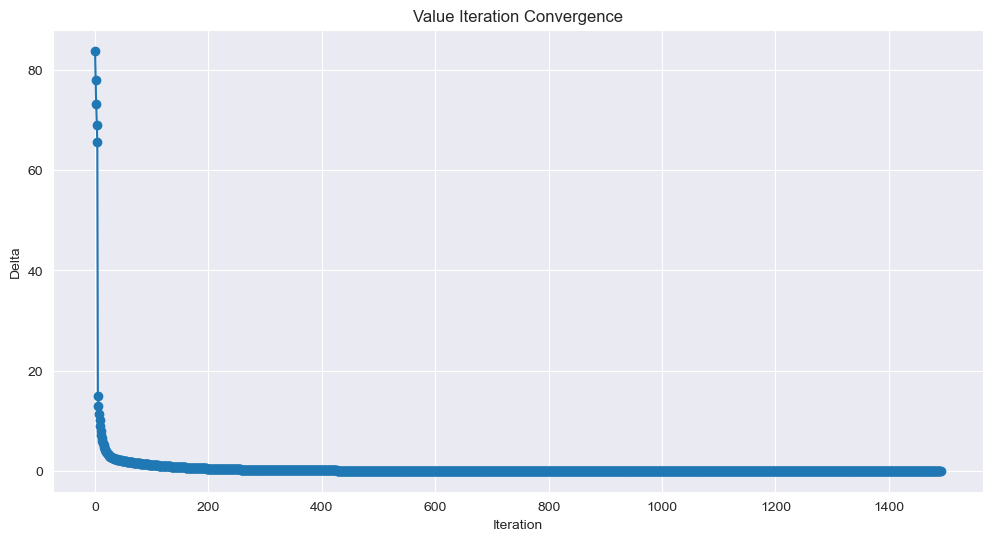

In [15]:
# Plot the deltas over the iterations
plt.figure(figsize=(12, 6))
plt.plot(optimizer.deltas[:], marker='o')
plt.title("Value Iteration Convergence")
plt.xlabel("Iteration")
plt.ylabel("Delta")
plt.grid(True)
plt.show()

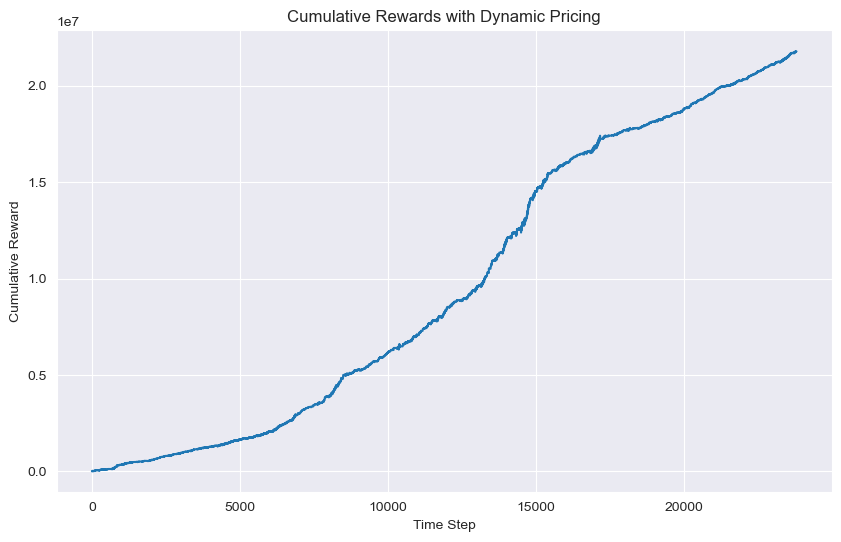

In [16]:
# Plot the rewards
plt.figure(figsize=(10, 6))
plt.plot(optimizer.rewards)
plt.title("Cumulative Rewards with Dynamic Pricing")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Reward")
plt.grid(True)
plt.show()

## MDP Model (using the policy iteration algorithm to define the best policy)

### 1 - Close Form  

V = (I - γ * P)^-1 * R

Where:
- V: The value function (vector).
- I: The identity matrix.
- γ: The discount factor.
- P: The state transition probability matrix.
- R: The reward vector.


This approach avoids iterative calculations by leveraging matrix operations for policy evaluation.


In [17]:
class BatteryPolicyIteration:
    def __init__(self, soc_levels, actions, price_dict, price_categories, transition_matrix, gamma=0.9):
        self.soc_levels = soc_levels
        self.actions = actions
        self.price_dict = price_dict
        self.price_categories = price_categories
        self.transition_matrix = transition_matrix.T  # Transpose for correct indexing
        self.gamma = gamma
        self.states = [(soc, category) for soc in soc_levels for category in price_categories]
        self.policy = {state: np.random.choice(actions) for state in self.states}
        self.value_function = {state: 0 for state in self.states}
        self.policy_convergence = []  # Track changes in the policy for convergence
        self.value_convergence = []  # Track value function convergence
        self.cumulative_rewards = []  # Track cumulative rewards during testing

    def is_valid_action(self, soc, action):
        """Check if the action is valid given the SOC."""
        return not (
            (action == "Discharge" and soc == 0) or
            (action == "Charge" and soc == max(self.soc_levels))
        )

    def get_next_soc(self, soc, action):
        """Determine the next SOC based on the action."""
        if action == "Charge":
            return min(soc + 100, max(self.soc_levels))
        elif action == "Discharge":
            return max(soc - 100, 0)
        return soc

    def reward(self, action, price):
        """Calculate the reward for a given action and price."""
        if action == "Charge":
            return -100 * price
        elif action == "Discharge":
            return 100 * price
        return 0

    def _evaluate_policy_closed_form(self, policy):
        """
        Evaluate the current policy using the closed-form solution for V = (I - gamma * P)^{-1} * R.
        """
        num_states = len(self.states)
        state_indices = {state: i for i, state in enumerate(self.states)}
        transitions = np.zeros((num_states, num_states))
        rewards = np.zeros(num_states)

        for idx, state in enumerate(self.states):
            soc, price_category = state
            action = policy[state]

            # Skip invalid actions
            if not self.is_valid_action(soc, action):
                continue

            next_soc = self.get_next_soc(soc, action)
            for next_category, prob in self.transition_matrix[price_category].items():
                next_state = (next_soc, next_category)
                if next_state in state_indices:
                    next_idx = state_indices[next_state]
                    transitions[idx, next_idx] += prob
                    rewards[idx] += prob * self.reward(action, self.price_dict[next_category])

        # Solve V = (I - gamma * P)^-1 * R
        I = np.eye(num_states)
        value_vector = np.linalg.inv(I - self.gamma * transitions).dot(rewards)

        # Map the value vector back to the value function dictionary
        value_function = {state: value_vector[i] for i, state in enumerate(self.states)}
        return value_function

    def policy_iteration(self):
        """
        Perform policy iteration using the closed-form solution for policy evaluation.
        Tracks policy and value convergence.
        """
        while True:
            # Policy evaluation (closed-form)
            old_value_function = self.value_function.copy()
            value_function = self._evaluate_policy_closed_form(self.policy)

            # Calculate value convergence (delta)
            delta = max(abs(value_function[state] - old_value_function[state]) for state in self.states)
            self.value_convergence.append(delta)

            # Policy improvement
            policy_stable = True
            updated_policy = self.policy.copy()
            changes = 0

            for state in self.states:
                soc, price_category = state
                old_action = self.policy[state]
                action_values = []
                valid_actions = []

                for action in self.actions:
                    if self.is_valid_action(soc, action):
                        next_soc = self.get_next_soc(soc, action)
                        expected_value = 0

                        for next_category, prob in self.transition_matrix[price_category].items():
                            next_state = (next_soc, next_category)
                            reward = self.reward(action, self.price_dict[next_category])
                            expected_value += prob * (reward + self.gamma * value_function[next_state])

                        action_values.append(expected_value)
                        valid_actions.append(action)

                if action_values:
                    best_action = valid_actions[np.argmax(action_values)]
                    updated_policy[state] = best_action
                    if best_action != old_action:
                        policy_stable = False
                        changes += 1

            self.policy = updated_policy
            self.value_function = value_function
            self.policy_convergence.append(changes)

            # If policy is stable (no changes), break
            if policy_stable:
                break

    def test_on_data(self, price_series, initial_soc=None):
        """Test the policy on a given price series."""
        self.rewards = []  # To track rewards at each step
        self.cumulative_rewards = []  # To track cumulative rewards
        cumulative_reward = 0
        self.battery_actions = []  # To store actions and states

        # Set the initial SOC (default to mid-level if not specified)
        if initial_soc is None:
            initial_soc = self.soc_levels[len(self.soc_levels) // 2]
        self.state = (initial_soc, price_series['Category'].iloc[0])

        for i in range(len(price_series) - 1):
            soc, price_category = self.state

            # Get the action from the policy
            action = self.policy.get(self.state)  # Default to "Nothing" if state not in policy

            # Calculate reward
            price = price_series['Price'].iloc[i]
            reward = self.reward(action, price)
            cumulative_reward += reward

            # Append rewards and cumulative rewards
            self.rewards.append(reward)
            self.cumulative_rewards.append(cumulative_reward)

            # Track actions and states
            self.battery_actions.append((self.state, action, price, price_category))

            # Get the next SOC and update state
            next_soc = self.get_next_soc(soc, action)
            next_price_category = price_series['Category'].iloc[i + 1]
            self.state = (next_soc, next_price_category)

        print("Testing complete. Final cumulative reward:", cumulative_reward)

    def get_policy(self):
        """Return the computed policy."""
        return self.policy

    def get_value_function(self):
        """Return the computed value function."""
        return self.value_function


### 2 - Iteration based
### TO be supress but can be usefull if we had much more states and action and that iversion to have the value function can not work or is way slower

In [18]:
import numpy as np

class BatteryPolicyIteration2:
    def __init__(self, soc_levels, actions, price_dict, price_categories, transition_matrix, gamma=0.9, epsilon=1e-6):
        self.soc_levels = soc_levels
        self.actions = actions
        self.price_dict = price_dict
        self.price_categories = price_categories
        self.transition_matrix = transition_matrix.T
        self.gamma = gamma
        self.states = [(soc, category) for soc in soc_levels for category in price_categories]
        self.policy = {state: np.random.choice(actions) for state in self.states}
        self.value_function = {state: 0 for state in self.states}
        self.convergence_deltas = []  # To track convergence during policy evaluation
        self.epsilon = epsilon
        self.cumulative_rewards = []  # To track cumulative rewards during testing

    def is_valid_action(self, soc, action):
        """Check if the action is valid given the SOC."""
        return not (
            (action == "Discharge" and soc == 0) or
            (action == "Charge" and soc == max(self.soc_levels))
        )

    def get_next_soc(self, soc, action):
        """Determine the next SOC based on the action."""
        if action == "Charge":
            return min(soc + 100, max(self.soc_levels))
        elif action == "Discharge":
            return max(soc - 100, 0)
        return soc

    def reward(self, action, price):
        """Calculate the reward for a given action and price."""
        if action == "Charge":
            return -100 * price
        elif action == "Discharge":
            return 100 * price
        return 0

    def _evaluate_policy(self, policy):
        """
        Evaluate the current policy to compute both the value function and the updated policy.
        Returns:
        - value_function: The computed value function.
        - updated_policy: The improved policy.
        - convergence_deltas: List of deltas for convergence tracking.
        """
        value_function = {state: 0 for state in self.states}
        updated_policy = policy.copy()
        convergence_deltas = []

        while True:
            delta = 0
            new_value_function = value_function.copy()

            for state in self.states:
                soc, price_category = state
                best_action = None
                best_value = float('-inf')

                for action in self.actions:
                    if not self.is_valid_action(soc, action):
                        continue

                    next_soc = self.get_next_soc(soc, action)
                    expected_value = 0

                    for next_category, prob in self.transition_matrix[price_category].items():
                        next_state = (next_soc, next_category)
                        reward = self.reward(action, self.price_dict[next_category])
                        expected_value += prob * (reward + self.gamma * value_function[next_state])

                    if expected_value > best_value:
                        best_value = expected_value
                        best_action = action

                new_value_function[state] = best_value
                updated_policy[state] = best_action
                delta = max(delta, abs(new_value_function[state] - value_function[state]))

            value_function = new_value_function
            convergence_deltas.append(delta)

            if delta < self.epsilon:
                break

        return value_function, updated_policy, convergence_deltas

    def policy_iteration(self):
        """
        Perform policy iteration using _evaluate_policy.
        Returns:
        - final_policy: The computed optimal policy.
        - final_value_function: The value function corresponding to the optimal policy.
        """
        policy = self.policy
        while True:
            value_function, updated_policy, deltas = self._evaluate_policy(policy)
            if policy == updated_policy:  # If the policy does not change, we have converged.
                break
            policy = updated_policy

        self.policy = policy
        self.value_function = value_function
        self.convergence_deltas = deltas

    def test_on_data(self, price_series, initial_soc=None):
        """Test the policy on a given price series."""
        self.rewards = []  # To track rewards at each step
        self.cumulative_rewards = []  # To track cumulative rewards
        cumulative_reward = 0
        self.battery_actions = []  # To store actions and states

        # Set the initial SOC (default to mid-level if not specified)
        if initial_soc is None:
            initial_soc = self.soc_levels[len(self.soc_levels) // 2]
        self.state = (initial_soc, price_series['Category'].iloc[0])

        for i in range(len(price_series) - 1):
            soc, price_category = self.state

            # Get the action from the policy
            action = self.policy.get(self.state)  # Default to "Nothing" if state not in policy

            # Calculate reward
            price = price_series['Price'].iloc[i]
            reward = self.reward(action, price)
            cumulative_reward += reward

            # Append rewards and cumulative rewards
            self.rewards.append(reward)
            self.cumulative_rewards.append(cumulative_reward)

            # Track actions and states
            self.battery_actions.append((self.state, action, price, price_category))

            # Get the next SOC and update state
            next_soc = self.get_next_soc(soc, action)
            next_price_category = price_series['Category'].iloc[i + 1]
            self.state = (next_soc, next_price_category)

        print("Testing complete. Final cumulative reward:", cumulative_reward)

    def get_policy(self):
        """Return the computed policy."""
        return self.policy

    def get_value_function(self):
        """Return the computed value function."""
        return self.value_function

In [19]:
# Policy Iteration

soc_levels = [0, 100, 200, 300, 400, 500]
actions = ["Charge", "Discharge", "Nothing"]
price_dict = {'Very Low': 0.1, 'Low': 0.3, 'Normal': 0.5, 'High': 0.7,  'Very High': 0.9}
price_categories = ['Very Low', 'Low', 'Normal', 'High', 'Very High']

policy_optimizer = BatteryPolicyIteration(soc_levels, actions, price_dict, price_categories, transition_matrix, gamma=0.99)
policy_optimizer.policy_iteration()

# Compare Policies and Value Functions
print("\nPolicy Iteration - Policy:")
for state, action in policy_optimizer.get_policy().items():
    print(f"State: {state}, Policy: {action}")

print("\nPolicy Iteration - Value Function:")
for state, value in policy_optimizer.get_value_function().items():
    print(f"State: {state}, Value: {value}")



Policy Iteration - Policy:
State: (0, 'Very Low'), Policy: Charge
State: (0, 'Low'), Policy: Charge
State: (0, 'Normal'), Policy: Charge
State: (0, 'High'), Policy: Nothing
State: (0, 'Very High'), Policy: Nothing
State: (100, 'Very Low'), Policy: Charge
State: (100, 'Low'), Policy: Charge
State: (100, 'Normal'), Policy: Nothing
State: (100, 'High'), Policy: Discharge
State: (100, 'Very High'), Policy: Discharge
State: (200, 'Very Low'), Policy: Charge
State: (200, 'Low'), Policy: Charge
State: (200, 'Normal'), Policy: Discharge
State: (200, 'High'), Policy: Discharge
State: (200, 'Very High'), Policy: Discharge
State: (300, 'Very Low'), Policy: Charge
State: (300, 'Low'), Policy: Charge
State: (300, 'Normal'), Policy: Discharge
State: (300, 'High'), Policy: Discharge
State: (300, 'Very High'), Policy: Discharge
State: (400, 'Very Low'), Policy: Charge
State: (400, 'Low'), Policy: Charge
State: (400, 'Normal'), Policy: Discharge
State: (400, 'High'), Policy: Discharge
State: (400, 'Ve

In [20]:
# Policy Iteration
policy_optimizer2 = BatteryPolicyIteration2(soc_levels, actions, price_dict, price_categories, transition_matrix, gamma=0.99)
policy_optimizer2.policy_iteration()

# Compare Policies and Value Functions
print("\nPolicy Iteration - Policy:")
for state, action in policy_optimizer2.get_policy().items():
    print(f"State: {state}, Policy: {action}")

print("\nPolicy Iteration - Value Function:")
for state, value in policy_optimizer2.get_value_function().items():
    print(f"State: {state}, Value: {value}")



Policy Iteration - Policy:
State: (0, 'Very Low'), Policy: Charge
State: (0, 'Low'), Policy: Charge
State: (0, 'Normal'), Policy: Charge
State: (0, 'High'), Policy: Nothing
State: (0, 'Very High'), Policy: Nothing
State: (100, 'Very Low'), Policy: Charge
State: (100, 'Low'), Policy: Charge
State: (100, 'Normal'), Policy: Nothing
State: (100, 'High'), Policy: Discharge
State: (100, 'Very High'), Policy: Discharge
State: (200, 'Very Low'), Policy: Charge
State: (200, 'Low'), Policy: Charge
State: (200, 'Normal'), Policy: Discharge
State: (200, 'High'), Policy: Discharge
State: (200, 'Very High'), Policy: Discharge
State: (300, 'Very Low'), Policy: Charge
State: (300, 'Low'), Policy: Charge
State: (300, 'Normal'), Policy: Discharge
State: (300, 'High'), Policy: Discharge
State: (300, 'Very High'), Policy: Discharge
State: (400, 'Very Low'), Policy: Charge
State: (400, 'Low'), Policy: Charge
State: (400, 'Normal'), Policy: Discharge
State: (400, 'High'), Policy: Discharge
State: (400, 'Ve

Testing complete. Final cumulative reward: 21781159.99330001


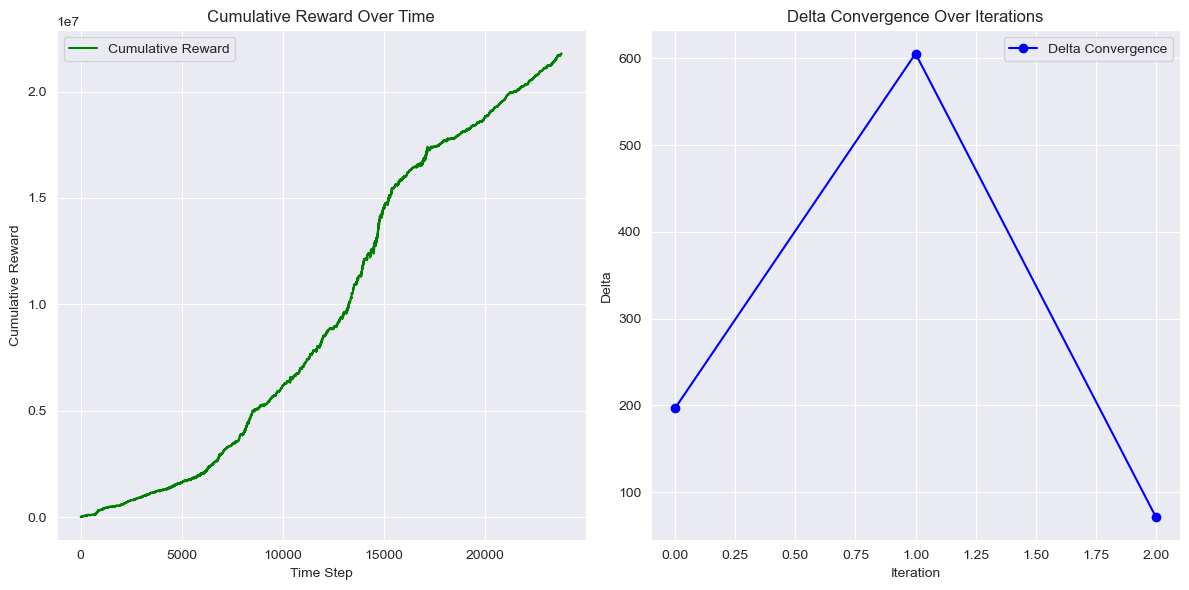

In [21]:
# Plot cumulative rewards and delta convergence
policy_optimizer.test_on_data(categorized_data,500)

plt.figure(figsize=(12, 6))

# Plot cumulative rewards
plt.subplot(1, 2, 1)
plt.plot(policy_optimizer.cumulative_rewards, label="Cumulative Reward", color="green")
# plt.plot(policy_optimizer.rewards, label="Cumulative Reward", color="red")
plt.title("Cumulative Reward Over Time")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Reward")
plt.grid(True)
plt.legend()

# Plot delta convergence
plt.subplot(1, 2, 2)
plt.plot(policy_optimizer.value_convergence, label="Delta Convergence", color="blue", marker='o')
plt.title("Delta Convergence Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Delta")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## Comparison models

In [22]:
# Get policies from both methods
policy_iteration_policy = policy_optimizer.get_policy()
value_iteration_policy = optimizer.get_policy()

# Compare the policies
print("\nComparison of Policies (Policy Iteration vs Value Iteration):")
mismatch_count = 0

for state in policy_iteration_policy.keys():
    pi_action = policy_iteration_policy[state]
    vi_action = value_iteration_policy.get(state, "Not Found")

    if pi_action != vi_action:
        mismatch_count += 1
        print(f"State: {state} -> Policy Iteration: {pi_action}, Value Iteration: {vi_action}")

if mismatch_count == 0:
    print("Both policies are identical.")
else:
    print(f"\nTotal mismatches: {mismatch_count}")



Comparison of Policies (Policy Iteration vs Value Iteration):
Both policies are identical.


Testing complete. Final cumulative reward: 21772399.99350001


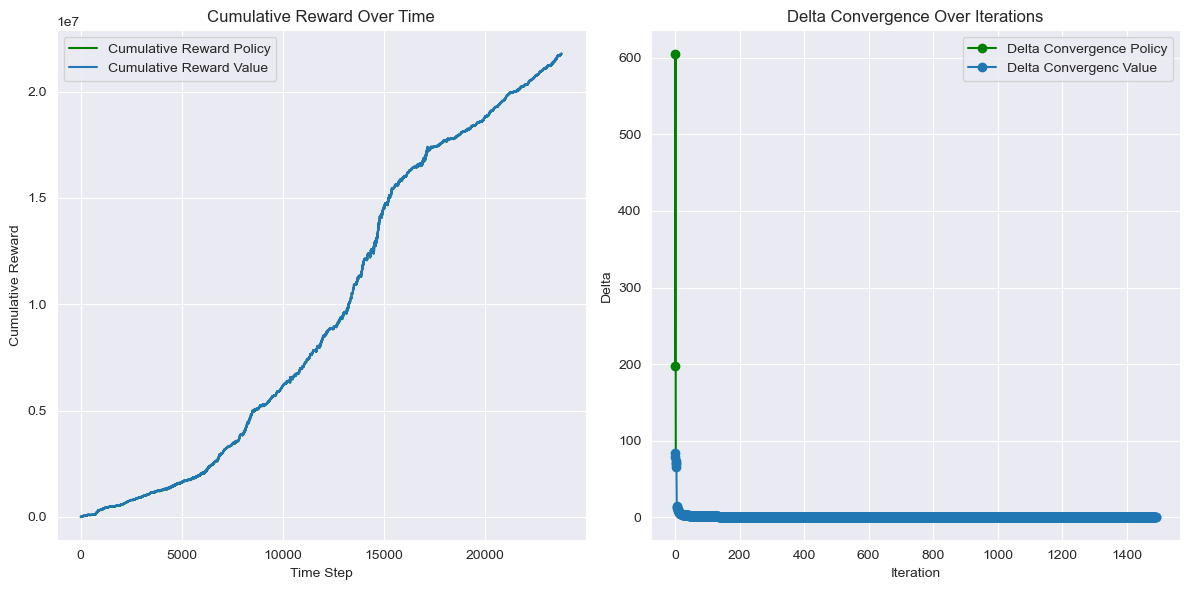

In [23]:
optimizer.test_on_data(categorized_data)
# Assuming policy_optimizer.test_on_data has been run successfully
# Plot cumulative rewards and delta convergence
policy_optimizer.test_on_data(categorized_data)

plt.figure(figsize=(12, 6))

# Plot cumulative rewards
plt.subplot(1, 2, 1)
plt.plot(policy_optimizer.cumulative_rewards, label="Cumulative Reward Policy", color="green")
plt.plot(optimizer.rewards, label="Cumulative Reward Value")
plt.title("Cumulative Reward Over Time")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Reward")
plt.grid(True)
plt.legend()


# Plot delta convergence
plt.subplot(1, 2, 2)
plt.plot(policy_optimizer.value_convergence, label="Delta Convergence Policy", color="green", marker='o')
plt.plot(optimizer.deltas, label="Delta Convergenc Value", marker='o')
plt.title("Delta Convergence Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Delta")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## Hyperparameter tuning

Starting Simplified Grid Search over 108 combinations...
Testing Config: {'rolling_window': 12, 'gamma': 0.98, 'num_classes': 4, 'epsilon': 0.05}
Testing complete. Final cumulative reward: 30545083.026799884
Reward: 30545083.03, Time: 6.48s
Testing Config: {'rolling_window': 12, 'gamma': 0.98, 'num_classes': 4, 'epsilon': 0.1}
Testing complete. Final cumulative reward: 30545083.026799884
Reward: 30545083.03, Time: 5.07s
Testing Config: {'rolling_window': 12, 'gamma': 0.98, 'num_classes': 4, 'epsilon': 0.2}
Testing complete. Final cumulative reward: 30545083.026799884
Reward: 30545083.03, Time: 6.49s
Testing Config: {'rolling_window': 12, 'gamma': 0.98, 'num_classes': 5, 'epsilon': 0.05}
Testing complete. Final cumulative reward: 21074339.053899895
Reward: 21074339.05, Time: 5.18s
Testing Config: {'rolling_window': 12, 'gamma': 0.98, 'num_classes': 5, 'epsilon': 0.1}
Testing complete. Final cumulative reward: 21074339.053899895
Reward: 21074339.05, Time: 5.08s
Testing Config: {'rolling_

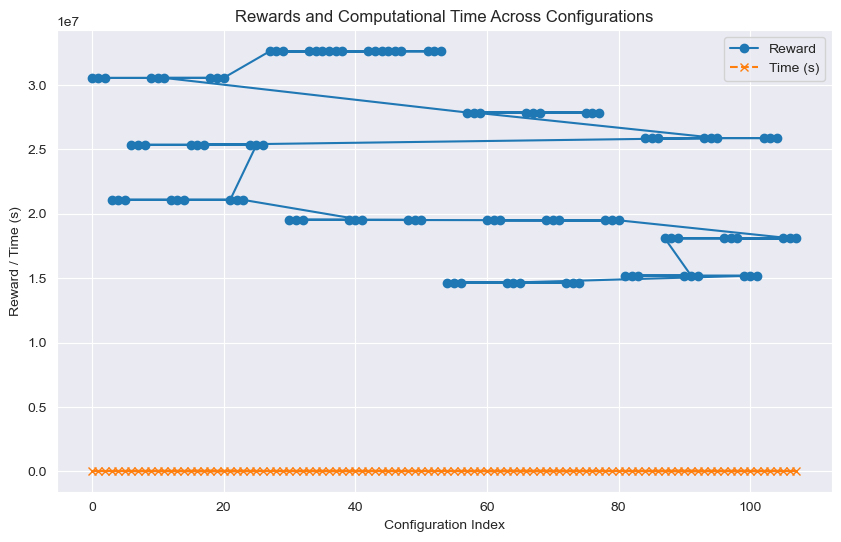

Top Configurations by Reward and Time:
    rolling_window  gamma  num_classes  epsilon        reward      time
44              24   0.99            6     0.20  3.261132e+07  5.060229
38              24   0.99            4     0.20  3.261132e+07  5.183464
28              24   0.98            4     0.10  3.261132e+07  5.103243
29              24   0.98            4     0.20  3.261132e+07  4.964564
33              24   0.98            6     0.05  3.261132e+07  5.066890


Starting Simplified Grid Search over 108 combinations...
Testing Config: {'rolling_window': 12, 'gamma': 0.98, 'num_classes': 4, 'epsilon': 0.05}
Testing complete. Final cumulative reward: 30545083.026799884
Reward: 30545083.03
Testing Config: {'rolling_window': 12, 'gamma': 0.98, 'num_classes': 4, 'epsilon': 0.1}
Testing complete. Final cumulative reward: 30545083.026799884
Reward: 30545083.03
Testing Config: {'rolling_window': 12, 'gamma': 0.98, 'num_classes': 4, 'epsilon': 0.2}
Testing complete. Final cumulative reward: 30545083.026799884
Reward: 30545083.03
Testing Config: {'rolling_window': 12, 'gamma': 0.98, 'num_classes': 5, 'epsilon': 0.05}
Testing complete. Final cumulative reward: 21074339.053899895
Reward: 21074339.05
Testing Config: {'rolling_window': 12, 'gamma': 0.98, 'num_classes': 5, 'epsilon': 0.1}
Testing complete. Final cumulative reward: 21074339.053899895
Reward: 21074339.05
Testing Config: {'rolling_window': 12, 'gamma': 0.98, 'num_classes': 5, 'epsilon': 0.2}
Tes

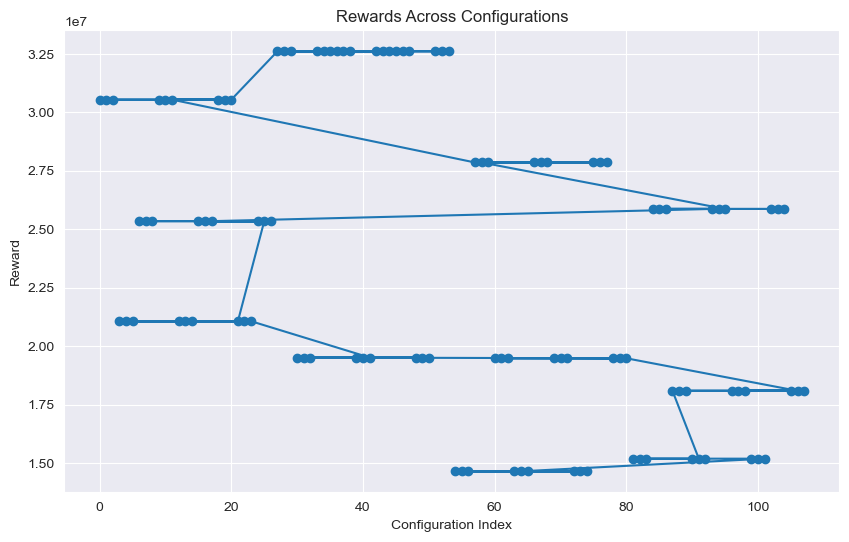

Top Configurations by Reward:
    rolling_window  gamma  num_classes  epsilon        reward
44              24   0.99            6     0.20  3.261132e+07
38              24   0.99            4     0.20  3.261132e+07
28              24   0.98            4     0.10  3.261132e+07
29              24   0.98            4     0.20  3.261132e+07
33              24   0.98            6     0.05  3.261132e+07


In [24]:
from itertools import product

def simplified_grid_search(data, param_grid):
    """
    Perform grid search with selected parameters: rolling_window, gamma, num_classes, epsilon.

    Parameters:
    - data: Input dataset.
    - param_grid: Dictionary of parameter ranges.

    Returns:
    - DataFrame with sorted results by reward.
    """
    results = []
    param_names = list(param_grid.keys())
    param_combinations = list(product(*param_grid.values()))

    print(f"Starting Simplified Grid Search over {len(param_combinations)} combinations...")

    for combination in param_combinations:
        params = dict(zip(param_names, combination))
        print(f"Testing Config: {params}")

        # Perform dynamic categorization
        categorized_data = dynamic_categorization(data.copy(), 'Price', 'Date', params['rolling_window'])
        
        # Bin and label the data
        zscore_min = categorized_data['ZScore'].min()
        zscore_max = categorized_data['ZScore'].max()
        bins = np.linspace(zscore_min - 0.1, zscore_max + 0.1, params['num_classes'] + 1)
        labels = [f"Class_{i}" for i in range(params['num_classes'])]
        categorized_data['Category'] = pd.cut(categorized_data['ZScore'], bins=bins, labels=labels, include_lowest=True)

        # Skip configurations with invalid categories
        if categorized_data['Category'].isna().any():
            print(f"Skipping due to NaN categories: {params}")
            continue

        # Calculate transition matrix
        transition_matrix = calculate_transition_matrix(categorized_data, 'Category')
        if (transition_matrix.sum(axis=1) == 0).any():
            print(f"Skipping due to invalid transition matrix: {params}")
            continue

        # Run optimization
        soc_levels = [0, 100, 200, 300, 400, 500]
        actions = ["Charge", "Discharge", "Nothing"]
        price_dict = {label: i * 0.2 for i, label in enumerate(labels)}

        policy_optimizer = BatteryPolicyIteration(soc_levels, 
                            actions, 
                            price_dict, 
                            labels, 
                            transition_matrix, 
                            gamma=0.99)

        policy_optimizer.policy_iteration()
        policy_optimizer.test_on_data(categorized_data)

        final_reward = policy_optimizer.cumulative_rewards[-1] if optimizer.rewards else 0
        results.append({**params, 'reward': final_reward})
        print(f"Reward: {final_reward:.2f}")

    # Convert results to DataFrame
    results_df = pd.DataFrame(results).sort_values(by='reward', ascending=False)
    print("\nTop Configurations:")
    print(results_df.head(5))
    return results_df


# Define parameter grid
param_grid = {
    'rolling_window': [12, 24, 48, 72],  # Vary rolling windows
    'gamma': [0.98, 0.99, 0.999],  # Discount factor
    'num_classes': [4, 5, 6],  # Number of classes
    'epsilon': [0.05, 0.1, 0.2]  # Convergence threshold
}

# Run the grid search
results_df = simplified_grid_search(data, param_grid)

# Select top 5 configurations
top_5_configs = results_df.head(5).to_dict(orient='records')

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(results_df['reward'], marker='o')
plt.title("Rewards Across Configurations")
plt.xlabel("Configuration Index")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

# Print top configurations
print("Top Configurations by Reward:")
print(results_df.head(5))

## Evaluation

In [25]:
# SOC levels and actions
soc_levels = [0, 100, 200, 300, 400, 500]
actions = ["Charge", "Discharge", "Nothing"]
price_dict = {'Very Low': 0.1, 'Low': 0.3, 'Normal': 0.5, 'High': 0.7,  'Very High': 0.9}
price_categories = ['Very Low', 'Low', 'Normal', 'High', 'Very High']

# Initialize and run value iteration
optimizer = BatteryValueIteration(soc_levels, actions, price_dict, categorized_data, price_categories, transition_matrix, gamma=0.99, epsilon=0.1)

(200, 'Normal')


In [26]:
class Expando(object):
    '''
        A small class which can have attributes set
    '''
    pass

In [27]:
import gurobipy as gp
from gurobipy import GRB

class OptimisationModel:
    def __init__(self, price_series, init_SOC=0, max_SOC=500, efficiency=1.0):
        self.price_t = price_series['Price']
        self.price_cat_t = price_series['Category']
        self.time = len(price_series)
        self.init_SOC = init_SOC
        self.max_SOC = max_SOC
        self.efficiency = efficiency  # Efficiency for charging/discharging
        
        self.results = {}
        self._build_model()
    
    def _build_model(self):
        self.m = gp.Model("Battery_Optimisation")
        
        # Decision Variables
        SOC = self.m.addVars(self.time, lb=0, ub=self.max_SOC, name="SOC")  # SOC level
        charge = self.m.addVars(self.time, lb=0, ub=1, vtype=GRB.BINARY, name="Charge")  # Charge binary
        discharge = self.m.addVars(self.time, lb=0, ub=1, vtype=GRB.BINARY, name="Discharge")  # Discharge binary

        # Constraints
        self.m.addConstr(SOC[0] == self.init_SOC, "InitialSOC")
        self.m.addConstrs(
            (SOC[i] == SOC[i - 1] + 100 * (charge[i] * self.efficiency - discharge[i] / self.efficiency)
             for i in range(1, self.time)), "SOC_Balance")
        self.m.addConstrs(
            (charge[i] + discharge[i] <= 1 for i in range(self.time)), "NoSimultaneousChargeDischarge")

        # Objective: Maximize rewards
        self.m.setObjective(
            gp.quicksum((discharge[i] * self.price_t[i] - charge[i] * self.price_t[i]) * 100 for i in range(self.time)),
            GRB.MAXIMIZE
        )

        # Solve
        self.m.optimize()

        # Store results
        self.results["objective"] = self.m.objVal
        self.results["SOC"] = [SOC[i].X for i in range(self.time)]
        self.results["charge"] = [charge[i].X for i in range(self.time)]
        self.results["discharge"] = [discharge[i].X for i in range(self.time)]
        self.results["rewards"] = self._compute_cumulative_rewards()

    def _compute_cumulative_rewards(self):
        """Compute cumulative rewards from the optimization results."""
        cumulative_rewards = []
        reward_cumul = 0
        for t in range(self.time):
            reward = (self.results["discharge"][t] * self.price_t[t] -
                      self.results["charge"][t] * self.price_t[t]) * 100
            reward_cumul += reward
            cumulative_rewards.append(reward_cumul)
        return cumulative_rewards


In [28]:
# Run the optimisation model
model = OptimisationModel(categorized_data)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-11
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 PRO 4750U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 47566 rows, 71349 columns and 142695 nonzeros
Model fingerprint: 0x1ab9496a
Variable types: 23783 continuous, 47566 integer (47566 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 9e+04]
  Bounds range     [1e+00, 5e+02]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 5086.9999000
Presolve removed 4 rows and 5 columns
Presolve time: 0.35s
Presolved: 47562 rows, 71344 columns, 142686 nonzeros
Variable types: 0 continuous, 71344 integer (47563 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 6.40s

In [29]:
# Compare Top 5 Configurations
def compare_top_5_with_optimization(data, top_5_configs, optimization_rewards):
    """
    Compare the rewards of the top 5 configurations with the optimization model reward over time.

    Parameters:
    - data: The dataset to use for categorization and testing.
    - top_5_configs: List of the top 5 configurations from hyperparameter tuning.
    - optimization_rewards: List of cumulative rewards from the optimization model.

    Returns:
    - A dictionary containing cumulative rewards and performance metrics for each top configuration.
    """
    soc_levels = [0, 100, 200, 300, 400, 500]
    actions = ["Charge", "Discharge", "Nothing"]
    top_configs_results = {}  # Store results for each configuration

    print("\nComparing Top 5 Configurations with Optimization Model:\n")

    for i, config in enumerate(top_5_configs):
        rolling_window = config['rolling_window']
        gamma = config['gamma']
        num_classes = config['num_classes']
        epsilon = config['epsilon']
        print(f"Processing Config {i + 1}: Rolling Window={rolling_window}, Gamma={gamma}, Num Classes={num_classes}")

        # Re-categorize the data with the specific rolling window
        categorized_data = dynamic_categorization(data.copy(), 'Price', 'Date', rolling_window)
        
        # Create bins and labels for categorization
        zscore_min = categorized_data['ZScore'].min()
        zscore_max = categorized_data['ZScore'].max()
        bins = np.linspace(zscore_min - 0.1, zscore_max + 0.1, num_classes + 1)
        labels = [f"Class_{i}" for i in range(num_classes)]
        categorized_data['Category'] = pd.cut(categorized_data['ZScore'], bins=bins, labels=labels, include_lowest=True)

        # Compute the transition matrix
        transition_matrix = calculate_transition_matrix(categorized_data, 'Category')

        # Initialize the optimizer with the specific gamma
        optimizer = BatteryValueIteration(
            soc_levels, actions, {label: i * 0.2 for i, label in enumerate(labels)},
            categorized_data, labels, transition_matrix, gamma=gamma, epsilon=epsilon
        )
        optimizer.value_iteration()
        optimizer.test_on_data(categorized_data)

        # Collect cumulative rewards for this configuration
        rewards = optimizer.rewards

        # Calculate percentage of total optimization reward
        final_reward_optimizer = rewards[-1] if rewards else 0
        final_reward_optimization = optimization_rewards[-1] if optimization_rewards else 1  # Avoid division by zero
        percentage_of_total = (final_reward_optimizer / final_reward_optimization) * 100

        print(f"Config {i + 1}:")
        print(f"  Final Reward: {final_reward_optimizer:.2f}")
        print(f"  Percentage of Optimal Reward: {percentage_of_total:.2f}%\n")

        # Save results
        top_configs_results[f"Config {i + 1}"] = {
            "rewards": rewards,
            "final_reward": final_reward_optimizer,
            "percentage_of_optimal": percentage_of_total,
        }

    return top_configs_results


Comparing Top 5 Configurations with Optimization Model:

Processing Config 1: Rolling Window=24, Gamma=0.99, Num Classes=6
(200, 'Class_2')
Config 1:
  Final Reward: 32606847.03
  Percentage of Optimal Reward: 56.32%

Processing Config 2: Rolling Window=24, Gamma=0.99, Num Classes=4
(200, 'Class_1')
Config 2:
  Final Reward: 32606847.03
  Percentage of Optimal Reward: 56.32%

Processing Config 3: Rolling Window=24, Gamma=0.98, Num Classes=4
(200, 'Class_1')
Config 3:
  Final Reward: 32606847.03
  Percentage of Optimal Reward: 56.32%

Processing Config 4: Rolling Window=24, Gamma=0.98, Num Classes=4
(200, 'Class_1')
Config 4:
  Final Reward: 32606847.03
  Percentage of Optimal Reward: 56.32%

Processing Config 5: Rolling Window=24, Gamma=0.98, Num Classes=6
(200, 'Class_2')
Config 5:
  Final Reward: 21983457.01
  Percentage of Optimal Reward: 37.97%

Config 1 Results:
  - Final Reward: 32606847.03
  - Percentage of Optimal Reward: 56.32%
Config 2 Results:
  - Final Reward: 32606847.03


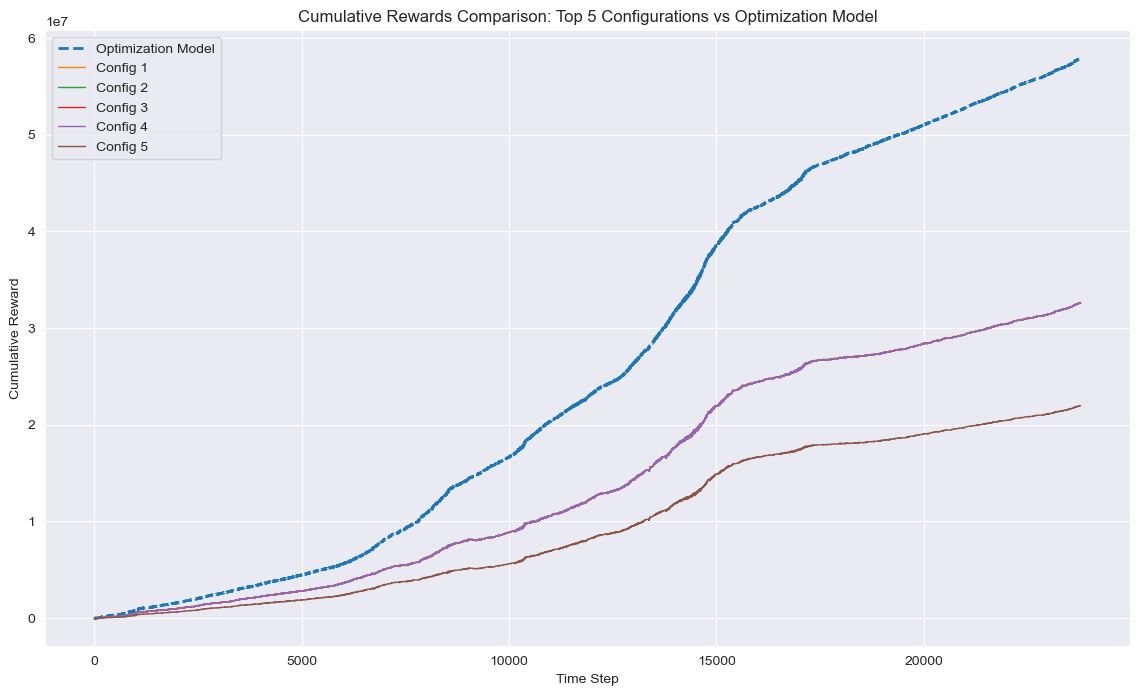

In [30]:
# Run the updated comparison function
top_configs_results = compare_top_5_with_optimization(data, top_5_configs, model.results["rewards"])

# Display the results
for config_name, results in top_configs_results.items():
    print(f"{config_name} Results:")
    print(f"  - Final Reward: {results['final_reward']:.2f}")
    print(f"  - Percentage of Optimal Reward: {results['percentage_of_optimal']:.2f}%")

# Plot cumulative rewards for top 5 configurations and the optimization model
plt.figure(figsize=(14, 8))
plt.plot(model.results["rewards"], label="Optimization Model", linewidth=2, linestyle="--")

# Add top 5 configurations to the plot
for config_name, results in top_configs_results.items():
    plt.plot(results['rewards'], label=config_name, linewidth=1)

# Formatting the plot
plt.title("Cumulative Rewards Comparison: Top 5 Configurations vs Optimization Model")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Reward")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [31]:
# Print the cumulative rewards of the optimisation model vs. the reinforcement learning model
plt.figure(figsize=(12, 6))
plt.plot(optimizer.rewards, label="Reinforcement Learning Value")
plt.plot(policy_optimizer.cumulative_rewards, label="Reinforcement Learning Policy")
plt.plot(model.results["rewards"], label="Optimisation Model")
plt.title("Cumulative Rewards Comparison")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True)
plt.show()

AttributeError: 'BatteryValueIteration' object has no attribute 'rewards'

<Figure size 1200x600 with 0 Axes>

In [ ]:
pourcerntage_of_total = optimizer.rewards[len(optimizer.rewards)-1]/model.results["rewards"][len(model.results["rewards"])-1]
print("The Reinforcement Learning model has achieved", pourcerntage_of_total*100, "% of the total reward of the Optimisation Model")